# 肝脏CT图像分割

## 1. 导入必要的库

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# DPU相关库
try:
    from pynq_dpu import DpuOverlay
    print("✓ PYNQ DPU库加载成功")
except ImportError:
    print("⚠ 未找到pynq_dpu，尝试使用vitis_ai_library")
    try:
        import vart
        import xir
        print("✓ VART库加载成功")
    except ImportError:
        print("❌ 请安装DPU运行时库")

✓ PYNQ DPU库加载成功


## 2. 设置参数和路径

In [3]:
# 图像处理参数
INPUT_SIZE = (512, 512)
IMG_MEAN = np.array([104.00698793, 116.66876762, 122.67891434], dtype=np.float32)

# 文件路径
MODEL_PATH = 'unet_chaos-CT_pt.xmodel'  # .xmodel模型文件
IMAGE_PATH = 'images_1/i0046,0000b.png'  # 修正后的图像路径
OUTPUT_NPY_PATH = 'images_npy_1/input_image.npy'  # 预处理后的npy文件保存到images_npy_1文件夹
OUTPUT_MASK_PATH = 'images_npy_1/segmentation_mask.npy'  # 分割结果npy文件保存到images_npy_1文件夹
OUTPUT_VIS_PATH = 'segmentation_result.png'  # 可视化结果

# 后处理参数
MIN_AREA_THRESHOLD = 1000  # 最小区域面积阈值

print("参数设置完成")

参数设置完成


## 3. 定义预处理函数

In [4]:
def preprocess_image(image_path, img_mean=IMG_MEAN, input_size=INPUT_SIZE):
    """
    预处理单张CT图像
    
    Args:
        image_path: 图像文件路径
        img_mean: 均值用于减法
        input_size: 目标尺寸 (width, height)
    
    Returns:
        image_array: 预处理后的图像数组 [1, 512, 512, 3]
        original_size: 原始图像尺寸 (H, W)
        original_image: 原始图像（用于可视化）
    """
    # 读取图像 (BGR格式)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"无法读取图像: {image_path}")
    
    print(f"原始图像尺寸: {image.shape}")
    
    # 保存原始图像和尺寸
    original_image = image.copy()
    original_size = image.shape[:2]  # (H, W)
    
    # 调整到512x512
    image = cv2.resize(image, input_size, interpolation=cv2.INTER_AREA)
    print(f"调整后尺寸: {image.shape}")
    
    # 转换为float32并进行均值减法
    image = np.asarray(image, np.float32)
    image -= img_mean
    
    # 保持HWC格式，只添加批次维度 [1, 512, 512, 3]
    image = image[np.newaxis, :, :, :]
    
    print(f"预处理后数组形状: {image.shape}")
    
    return image, original_size, original_image

print("预处理函数定义完成")

预处理函数定义完成


## 4. 定义后处理函数

In [5]:
def remove_small_regions(mask, min_area_threshold=1000):
    """
    去除小的误判区域,只保留最大的肝脏区域
    
    Args:
        mask: 二值掩码 (0-255)
        min_area_threshold: 最小区域面积阈值
    
    Returns:
        处理后的掩码
    """
    # 查找所有连通区域
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        mask, connectivity=8)
    
    if num_labels <= 1:  # 没有前景区域
        return mask
    
    # 找到最大区域
    areas = stats[1:, cv2.CC_STAT_AREA]  # 忽略背景
    max_area_idx = np.argmax(areas) + 1
    
    # 如果最大区域面积超过阈值,只保留最大区域
    if areas[max_area_idx - 1] > min_area_threshold:
        result_mask = np.zeros_like(mask, dtype=np.uint8)
        result_mask[labels == max_area_idx] = 255
        print(f"保留最大区域,面积: {areas[max_area_idx - 1]} 像素")
        return result_mask
    else:
        print(f"未找到足够大的区域 (阈值: {min_area_threshold})")
        return np.zeros_like(mask, dtype=np.uint8)


def postprocess_mask(mask, min_area_threshold=1000):
    """
    完整的后处理流水线
    
    Args:
        mask: 原始推理结果掩码
        min_area_threshold: 最小面积阈值
    
    Returns:
        清理后的掩码
    """
    # 1. 去除小区域,保留最大区域
    mask = remove_small_regions(mask, min_area_threshold=min_area_threshold)
    
    # 2. 填充空洞
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 3. 平滑边界
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


def postprocess_output(output, original_size, min_area_threshold=1000):
    """
    后处理模型输出 - 适配新的[1, 512, 512, 2]格式
    
    Args:
        output: 模型原始输出 [1, 512, 512, 2]
        original_size: 原始图像尺寸 (H, W)
        min_area_threshold: 最小面积阈值
    
    Returns:
        mask: 分割掩码,调整到原始尺寸
    """
    print(f"原始输出形状: {output.shape}")
    
    # 新格式: [1, 512, 512, 2] -> [512, 512]
    # 在最后一个维度上做argmax (在通道维度上)
    mask = np.argmax(output[0], axis=-1)  # [512, 512]
    
    print(f"argmax后形状: {mask.shape}, 唯一值: {np.unique(mask)}")
    
    # 转为0-255范围
    mask = mask.astype(np.uint8) * 255
    
    print(f"转换为二值后形状: {mask.shape}, 唯一值: {np.unique(mask)}")
    
    # 后处理去噪
    mask = postprocess_mask(mask, min_area_threshold=min_area_threshold)
    
    # 调整回原始尺寸
    mask = cv2.resize(mask.astype(np.uint8),
                     (original_size[1], original_size[0]),
                     interpolation=cv2.INTER_NEAREST)
    
    print(f"最终掩码形状: {mask.shape}")
    
    return mask

print("后处理函数定义完成")

后处理函数定义完成


## 5. 加载DPU模型

In [6]:
# 加载DPU overlay
from pynq_dpu import DpuOverlay

# 加载DPU overlay (需要指定你的bit文件)
overlay = DpuOverlay("dpu.bit")  # 替换为实际的bit文件路径

print("✓ DPU overlay加载成功")

✓ DPU overlay加载成功


## 6. 加载.xmodel模型

In [7]:
# 加载.xmodel模型到DPU
try:
    overlay.load_model(MODEL_PATH)
    print("✓ DPU模型加载成功")
    print(f"模型文件: {MODEL_PATH}")
    
    # 获取输入输出tensor信息
    dpu = overlay.runner
    input_tensors = dpu.get_input_tensors()
    output_tensors = dpu.get_output_tensors()
    
    print(f"输入tensor数量: {len(input_tensors)}")
    print(f"输出tensor数量: {len(output_tensors)}")
    
    # 打印输入输出信息
    for i, tensor in enumerate(input_tensors):
        print(f"输入 {i}: 形状={tensor.dims}, 名称={tensor.name}")
    for i, tensor in enumerate(output_tensors):
        print(f"输出 {i}: 形状={tensor.dims}, 名称={tensor.name}")
        
except Exception as e:
    print(f"模型加载失败: {e}")
    print("\n请确保:")
    print("1. .xmodel文件路径正确")
    print("2. DPU overlay已正确加载")
    print("3. 模型与当前DPU配置兼容")

✓ DPU模型加载成功
模型文件: unet_chaos-CT_pt.xmodel
输入tensor数量: 1
输出tensor数量: 1
输入 0: 形状=[1, 512, 512, 3], 名称=unet__input_0_fix
输出 0: 形状=[1, 512, 512, 2], 名称=unet__unet_Conv2d_final__430_fix


## 6. 加载和预处理图像

In [8]:
# 预处理图像
input_array, original_size, original_image = preprocess_image(IMAGE_PATH)

# 保存预处理后的numpy数组
np.save(OUTPUT_NPY_PATH, input_array)
print(f"\n预处理后的图像已保存为: {OUTPUT_NPY_PATH}")
print(f"形状: {input_array.shape}")

原始图像尺寸: (512, 512, 3)
调整后尺寸: (512, 512, 3)
预处理后数组形状: (1, 512, 512, 3)

预处理后的图像已保存为: images_npy_1/input_image.npy
形状: (1, 512, 512, 3)


## 7. DPU推理

In [9]:
print("开始DPU推理...")

try:
    # 准备输入数据
    input_data = [input_array.astype(np.float32)]
    
    # 准备输出缓冲
    output_data = []
    for output_tensor in output_tensors:
        output_shape = tuple(output_tensor.dims)
        output_data.append(np.empty(output_shape, dtype=np.float32))
    
    # 执行推理
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # 获取输出
    output = output_data[0]  # 假设只有一个输出
    print(f"✓ 推理完成! 输出形状: {output.shape}")
    print(f"输出值范围: [{output.min():.4f}, {output.max():.4f}]")
    
except Exception as e:
    print(f"推理失败: {e}")
    output = None

开始DPU推理...
✓ 推理完成! 输出形状: (1, 512, 512, 2)
输出值范围: [-32.0000, 27.2500]


## 8. 后处理和保存结果

In [10]:
if output is not None:
    # 后处理得到分割掩码
    mask = postprocess_output(output, original_size, min_area_threshold=MIN_AREA_THRESHOLD)
    
    # 保存分割掩码为npy文件
    np.save(OUTPUT_MASK_PATH, mask)
    print(f"\n分割掩码已保存为: {OUTPUT_MASK_PATH}")
    print(f"掩码形状: {mask.shape}")
    print(f"掩码值范围: {mask.min()} - {mask.max()}")
    print(f"肝脏像素数量: {np.sum(mask > 0)}")
else:
    print("无法进行后处理,推理未成功")

原始输出形状: (1, 512, 512, 2)
argmax后形状: (512, 512), 唯一值: [0 1]
转换为二值后形状: (512, 512), 唯一值: [  0 255]
保留最大区域,面积: 20798 像素
最终掩码形状: (512, 512)

分割掩码已保存为: images_npy_1/segmentation_mask.npy
掩码形状: (512, 512)
掩码值范围: 0 - 255
肝脏像素数量: 20813


## 9. 可视化结果


可视化结果已保存为: segmentation_result.png


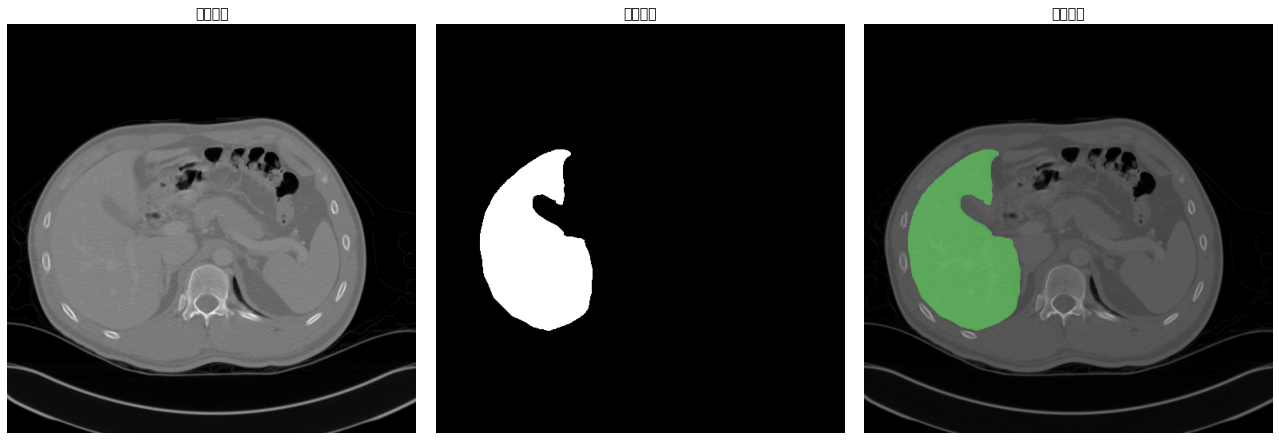

In [11]:
if output is not None:
    # 创建可视化
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 原始图像 (BGR转RGB)
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('原始图像', fontsize=14)
    axes[0].axis('off')
    
    # 分割掩码
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('分割掩码', fontsize=14)
    axes[1].axis('off')
    
    # 叠加显示
    overlay_img = original_image.copy()
    # 创建彩色掩码 (绿色)
    mask_colored = np.zeros_like(original_image)
    mask_colored[:, :, 1] = mask  # 绿色通道
    # 叠加
    overlay_img = cv2.addWeighted(original_image, 0.7, mask_colored, 0.3, 0)
    axes[2].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('叠加显示', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_VIS_PATH, dpi=150, bbox_inches='tight')
    print(f"\n可视化结果已保存为: {OUTPUT_VIS_PATH}")
    plt.show()

## 10. 统计信息

In [12]:
if output is not None:
    # 计算分割统计信息
    total_pixels = mask.shape[0] * mask.shape[1]
    liver_pixels = np.sum(mask > 0)
    liver_ratio = liver_pixels / total_pixels * 100
    
    print("\n========== 分割结果统计 ==========")
    print(f"图像尺寸: {mask.shape[1]} x {mask.shape[0]}")
    print(f"总像素数: {total_pixels:,}")
    print(f"肝脏像素数: {liver_pixels:,}")
    print(f"肝脏占比: {liver_ratio:.2f}%")
    print("================================\n")


========== 分割结果统计 ==========
图像尺寸: 512 x 512
总像素数: 262,144
肝脏像素数: 20,813
肝脏占比: 7.94%



In [13]:
# 释放DPU资源
try:
    del dpu
    print("DPU资源已释放")
except:
    pass

DPU资源已释放


In [14]:
# 彻底清理内存 - 减少内存占用
import gc
import sys

def cleanup_memory():
    """清理内存中的变量和缓存"""
    
    print("🧹 开始清理内存...")
    
    # 1. 清理DPU相关资源 (如果还有残留)
    dpu_vars = ['dpu', 'overlay', 'input_tensors', 'output_tensors']
    for var in dpu_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除变量: {var}")
            except:
                pass
    
    # 2. 清理图像处理相关的大型数组
    image_vars = ['input_array', 'output_data', 'mask', 'original_image', 
                  'overlay_img', 'mask_colored', 'display_image']
    for var in image_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除图像数组: {var}")
            except:
                pass
    
    # 3. 清理处理结果和中间变量
    result_vars = ['output', 'result_mask', 'labels', 'stats', 'centroids']
    for var in result_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除处理结果: {var}")
            except:
                pass
    
    # 4. 清理函数和变量引用
    func_vars = ['preprocess_image', 'postprocess_output', 'remove_small_regions', 
                 'postprocess_mask']
    for var in func_vars:
        if var in globals():
            try:
                del globals()[var]
                print(f"✓ 删除函数: {var}")
            except:
                pass
    
    # 5. 强制垃圾回收
    collected = gc.collect()
    print(f"✓ 垃圾回收完成，清理了 {collected} 个对象")
    
    # 6. 清理matplotlib缓存
    try:
        plt.close('all')
        print("✓ 清理matplotlib图形缓存")
    except:
        pass
    
    # 7. 清理OpenCV缓存
    try:
        cv2.destroyAllWindows()
        print("✓ 清理OpenCV窗口缓存")
    except:
        pass
    
    # 8. 显示内存使用情况
    try:
        import psutil
        process = psutil.Process()
        memory_info = process.memory_info()
        memory_mb = memory_info.rss / 1024 / 1024
        
        print(f"\n📊 当前内存使用情况:")
        print(f"  RSS内存: {memory_mb:.1f} MB")
        print(f"  VMS内存: {memory_info.vms / 1024 / 1024:.1f} MB")
        
        if memory_mb > 500:  # 如果内存使用超过500MB
            print("⚠️  内存使用较高，建议重启kernel")
        else:
            print("✓ 内存使用正常")
            
    except ImportError:
        print("  (psutil未安装，无法显示内存信息)")
    
    return memory_mb if 'memory_mb' in locals() else None

# 执行内存清理
final_memory = cleanup_memory()

print(f"\n🎉 内存清理完成!")
print(f"💾 预处理后的NPY文件保存在: {OUTPUT_NPY_PATH}")
print(f"🎭 分割掩码NPY文件保存在: {OUTPUT_MASK_PATH}")
print(f"🖼️  可视化结果保存在: {OUTPUT_VIS_PATH}")
print(f"\n💡 提示: 如需进一步释放内存，可以重启Jupyter kernel")

# 最终状态检查
try:
    # 清理后再次垃圾回收
    final_collected = gc.collect()
    print(f"🔚 最终清理: 回收了 {final_collected} 个额外对象")
except:
    pass

🧹 开始清理内存...
✓ 删除变量: overlay
✓ 删除变量: input_tensors
✓ 删除变量: output_tensors
✓ 删除图像数组: input_array
✓ 删除图像数组: output_data
✓ 删除图像数组: mask
✓ 删除图像数组: original_image
✓ 删除图像数组: overlay_img
✓ 删除图像数组: mask_colored
✓ 删除处理结果: output
✓ 删除函数: preprocess_image
✓ 删除函数: postprocess_output
✓ 删除函数: remove_small_regions
✓ 删除函数: postprocess_mask
✓ 垃圾回收完成，清理了 40 个对象
✓ 清理matplotlib图形缓存
✓ 清理OpenCV窗口缓存

📊 当前内存使用情况:
  RSS内存: 243.9 MB
  VMS内存: 1503.9 MB
✓ 内存使用正常

🎉 内存清理完成!
💾 预处理后的NPY文件保存在: images_npy_1/input_image.npy
🎭 分割掩码NPY文件保存在: images_npy_1/segmentation_mask.npy
🖼️  可视化结果保存在: segmentation_result.png

💡 提示: 如需进一步释放内存，可以重启Jupyter kernel
🔚 最终清理: 回收了 0 个额外对象
